# Imports

In [1]:
import datetime
import json
import os
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from path_constants import (
    DELAYED_AUDIO_DIR,
    MATRICES_DELAY_DIR,
    METADATA_DELAY_OUTPUT,
    MODELS_DELAY_DIR,
)

# Suppress specific warnings related to NVML (NVIDIA Management Library) initialization
warnings.filterwarnings("ignore", message="Can't initialize NVML")

# GPU Device Setup

In [2]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Print more detailed device information and ensure device is set accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA not available. Using CPU.")

Using device: cuda
Using GPU: NVIDIA GeForce RTX 5090


# Path Constants

In [3]:
# Base path constants
metadata_file = METADATA_DELAY_OUTPUT
delayed_audio_samples_dir = DELAYED_AUDIO_DIR

models_delay_dir = MODELS_DELAY_DIR
os.makedirs(MATRICES_DELAY_DIR, exist_ok=True
            )
transition_matrices_dir = MATRICES_DELAY_DIR
os.makedirs(MATRICES_DELAY_DIR, exist_ok=True)

# Generate timestamp for this run
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a timestamped subfolder for all outputs from this run
current_run_dir = os.path.join(models_delay_dir, f"delay_run_{timestamp}")
os.makedirs(current_run_dir, exist_ok=True)

# Create checkpoint directory inside the run folder
checkpoint_dir = os.path.join(current_run_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Define all output file paths within the timestamped run directory
transition_matrix_path = os.path.join(transition_matrices_dir, f"matrix_delay_run_{timestamp}.npy")
delay_model_path = os.path.join(current_run_dir, f"delay_full_model_{timestamp}.pt")
log_file_path = os.path.join(current_run_dir, f"delay_model_log_{timestamp}.txt")
pca_plot_path = os.path.join(current_run_dir, f"feature_space_pca_{timestamp}.png")
loss_plot_path = os.path.join(current_run_dir, f"loss_curves_{timestamp}.png")

# Flag to Determine if an Existing Model is Loaded or a New One is Trained

In [4]:
# Set to True when you want to load an existing model
load_existing_model = False

# Path to existing model when load_existing_model is True
existing_model_path = None

# Create log file for capturing all print output

In [5]:
# Create log file path with same timestamp
log_file = open(log_file_path, 'w', encoding='utf-8')

# Store the original print function
original_print = print

# Define a new print function that writes to both console and file
def print(*args, **kwargs):
    # Call the original print function
    original_print(*args, **kwargs)

    # Also write to the log file
    kwargs_copy = kwargs.copy()
    if 'file' in kwargs_copy:
        del kwargs_copy['file']  # Remove file parameter if present

    # Convert all arguments to strings and join with spaces
    output = ' '.join(str(arg) for arg in args)

    # Add newline if not explicitly suppressed
    end = kwargs_copy.get('end', '\n')
    output += end

    # Write to log file
    log_file.write(output)
    log_file.flush()  # Ensure writes aren't buffered

# Inform user about logging
original_print(f"Logging all print statements to the specified file.")

Logging all print statements to the specified file.


# Load Metadata

In [6]:
"""
Load metadata from the JSON file specified by METADATA_DELAY_OUTPUT.
The metadata file should be generated by running delay_effect.py.
Raises FileNotFoundError with a helpful message if the file does not exist.
"""

try:
    with open(metadata_file) as f:
        metadata = json.load(f)
    print(f"Successfully loaded metadata with {len(metadata)} entries")
except FileNotFoundError:
    raise FileNotFoundError(f"Metadata file not found at {metadata_file}. Please run delay_effect.py first to generate the metadata.")

Successfully loaded metadata with 6900 entries


# Dataset Class Definition

In [7]:
class DelayDataset(Dataset):
    """
    PyTorch Dataset for loading and normalizing audio delay metadata.

    Args:
        metadata (list): List of metadata dictionaries, each containing features and state info.
        root_dir (str): Directory containing the audio samples (not directly used here).
        state_to_index (dict): Mapping from state names to integer indices.

    Attributes:
        meta (list): The metadata list.
        root (str): The root directory for audio samples.
        state_to_idx (dict): State name to index mapping.
        feature_means (np.ndarray): Mean of each feature across the dataset.
        feature_stds (np.ndarray): Standard deviation of each feature across the dataset.
    """

    def __init__(self, metadata, root_dir, state_to_index):
        """
        Initialize the DelayDataset, compute normalization statistics.

        Args:
            metadata (list): List of metadata dictionaries.
            root_dir (str): Directory containing audio samples.
            state_to_index (dict): Mapping from state names to indices.
        """

        self.meta = metadata
        self.root = root_dir
        self.state_to_idx = state_to_index

        # Calculate normalization statistics from data
        features_list = []

        # Extract features from metadata
        for row in metadata:
            features = [
                row["rms"],
                row["zero_crossing_rate"],
                row["spectral_centroid"],
                row["spectral_bandwidth"],
                row["spectral_flatness"],
                row["peak_amplitude"],
                row["delay_time_ms"]
            ] + row["mfcc_mean"] + row["mfcc_std"]
            features_list.append(features)

        # Convert to numpy array for mean/std calculation
        features_array = np.array(features_list)
        self.feature_means = features_array.mean(axis=0)
        self.feature_stds = features_array.std(axis=0)
        self.feature_stds = np.where(self.feature_stds == 0, 1.0, self.feature_stds) # Avoid division by zero

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """

        return len(self.meta)

    def __getitem__(self, idx):
        """
        Retrieve a normalized feature tensor and state indices for a given index.

        Args:
            idx (int): Index of the sample.

        Returns:
            features (torch.Tensor): Normalized feature vector.
            current_state (torch.Tensor): Index of the current state.
            next_state (torch.Tensor): Index of the next state (or current if not present).
        """

        # Get metadata for this item
        item = self.meta[idx]

        # Extract features
        features = [
            item["rms"],
            item["zero_crossing_rate"],
            item["spectral_centroid"],
            item["spectral_bandwidth"],
            item["spectral_flatness"],
            item["peak_amplitude"],
            item["delay_time_ms"]
        ] + item["mfcc_mean"] + item["mfcc_std"]

        # Convert to tensor and normalize
        features = torch.tensor(features, dtype=torch.float32)
        features = (features - torch.tensor(self.feature_means, dtype=torch.float32)) / torch.tensor(self.feature_stds, dtype=torch.float32)

        # Get current and next state indices
        current_state = torch.tensor(self.state_to_idx[item["state"]], dtype=torch.long)
        next_state = torch.tensor(self.state_to_idx[item["next_state"]] if "next_state" in item else self.state_to_idx[item["state"]], dtype=torch.long)

        # Return the features and states
        return features, current_state, next_state

# Data Loading

In [8]:
# Mapping of state names to integer indices for classification
state_to_index = {'short': 0, 'medium': 1, 'long': 2}

# Split the metadata into training and validation sets (80% train, 20% validation)
train_meta, val_meta = train_test_split(metadata, test_size=0.2, random_state=42)

# Create PyTorch datasets for training and validation
train_dataset = DelayDataset(train_meta, delayed_audio_samples_dir, state_to_index)
val_dataset = DelayDataset(val_meta, delayed_audio_samples_dir, state_to_index)

# Create data loaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Calculate the number of MFCC coefficients for feature dimensionality
mfcc_count = len(metadata[0]["mfcc_mean"])

# Total feature dimension: 2 * MFCC (mean + std) + 6 spectral features + 1 delay time
feature_dim = 2 * mfcc_count + 6 + 1

# Print dataset information
print(f"Feature dimension: {feature_dim}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Feature dimension: 33
Training samples: 5520
Validation samples: 1380


# Feature Analysis

Feature space PCA plot saved to the specified path.


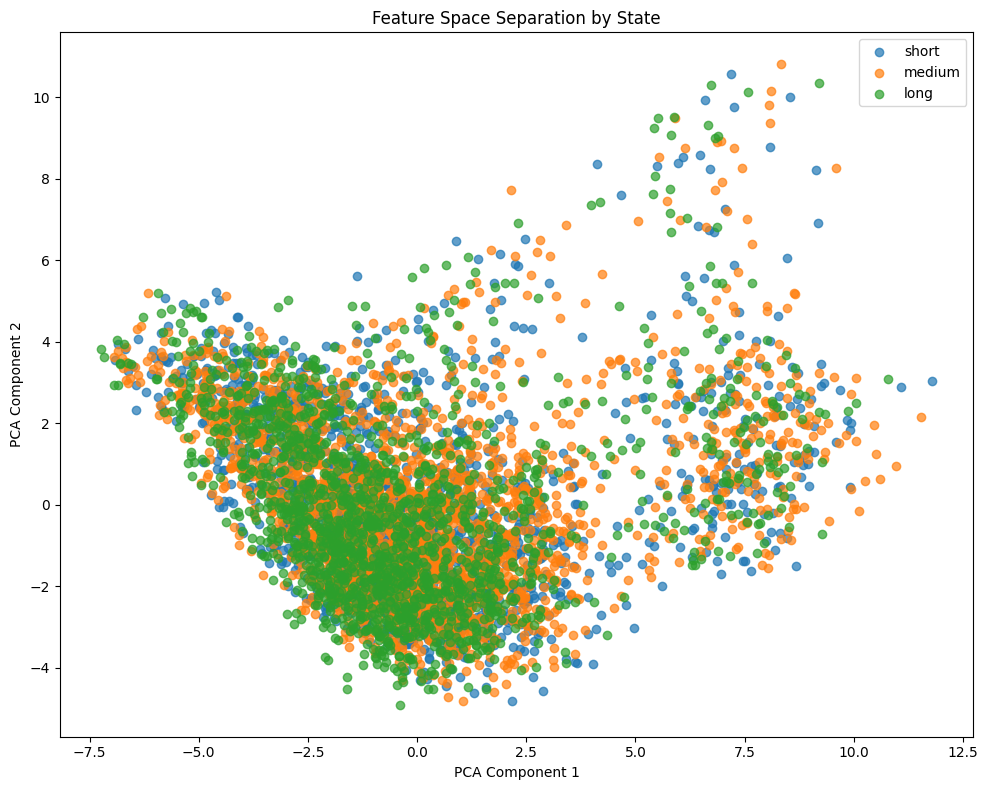

In [9]:
def analyze_feature_discrimination():
    """
    Analyze the discriminative power of features for state classification.

    This function performs the following steps:
    - Collects all features and state labels from the training set.
    - Reduces feature dimensionality to 2D using PCA (Principal Component Analysis) for visualization.
    - Plots the 2D feature space colored by state.

    The resulting plot helps visualize how well the audio features separate the three delay states (short, medium, long) in 2D space.
    """
    all_features = []
    all_states = []

    # Collect features and states from training set
    for batch in train_loader:
        features, states, _ = batch
        all_features.append(features)
        all_states.append(states)

    features = torch.cat(all_features, dim=0).numpy()
    states = torch.cat(all_states, dim=0).numpy()

    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # Plot the 2D PCA projection, colored by state
    plt.figure(figsize=(10, 8))
    for i, state_name in enumerate(['short', 'medium', 'long']):
        mask = states == i
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                    label=state_name, alpha=0.7)

    """
    PCA Component 1 captures the direction of greatest variance in the data, while PCA Component 2 captures the second greatest variance.
    This allows visualization of how well the audio features separate the three delay states (short, medium, long) in 2D space.
    """

    plt.title('Feature Space Separation by State')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    # Save plot before showing it
    plt.tight_layout()
    pca_plot_path = os.path.join(current_run_dir, f"feature_space_pca_{timestamp}.png")
    plt.savefig(pca_plot_path)
    print(f"Feature space PCA plot saved to the specified path.")


# Run the feature analysis
if not load_existing_model:
    analyze_feature_discrimination()
else:
    print("Skipping feature analysis (loading existing model)")

# Improved Model Definition

In [10]:
class SequentialDelayModel(nn.Module):
    """
    A neural network model for sequential delay state prediction.

    Architecture:
    - Feature encoder: Linear -> BatchNorm -> LeakyReLU -> Dropout
    - Bidirectional GRU for temporal pattern extraction
    - State embedding for current state representation
    - Classifier: Deep MLP with BatchNorm, LeakyReLU, Dropout

    Args:
        n_states (int): Number of possible states.
        feature_dim (int): Input feature dimension.
        hidden_dim (int, optional): Hidden layer size. Default is 256.
    """

    def __init__(self, n_states, feature_dim, hidden_dim=256):
        """
        Initialize the SequentialDelayModel.

        Args:
            n_states (int): Number of possible states.
            feature_dim (int): Input feature dimension.
            hidden_dim (int, optional): Hidden layer size. Default is 256.
        """

        super().__init__()

        # Feature processing with stronger regularization
        self.feature_encoder = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )

        # Add recurrent layer for temporal patterns
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        # State embedding
        self.state_embedding = nn.Embedding(n_states, hidden_dim)

        # Output layers with deeper network
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, n_states)
        )

    def forward(self, state_idx, features):
        """
        Forward pass of the model.

        Args:
            state_idx (Tensor): Tensor of current state indices, shape [batch].
            features (Tensor): Input features, shape [batch, feature_dim].

        Returns:
            Tensor: Log-probabilities for each possible next state, shape [batch, n_states].
        """

        batch_size = features.size(0)

        # Process features
        x = self.feature_encoder(features)

        # Reshape for GRU [batch, 1, features]
        x_seq = x.unsqueeze(1)

        # Process through GRU (bidirectional doubles output size)
        gru_out, _ = self.gru(x_seq)
        gru_features = gru_out.squeeze(1)  # Shape: [batch, 2*hidden_dim]

        # Get state embedding
        state_emb = self.state_embedding(state_idx)

        # Combine features
        combined = torch.cat([x, gru_features, state_emb], dim=1)

        # Classify
        logits = self.classifier(combined)

        # Return log probabilities
        return F.log_softmax(logits, dim=1)

# Load Existing Model

In [11]:
# Model loading section
if load_existing_model and existing_model_path:
    # Define hidden_dim explicitly
    hidden_dim = 256  # Ensure this matches the value used during training

    # Load the saved model
    checkpoint = torch.load(existing_model_path)

    # Create model instance
    model = SequentialDelayModel(
        n_states=3,
        feature_dim=feature_dim,
        hidden_dim=hidden_dim
    ).to(device)

    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])

    # Get normalization parameters from saved model
    feature_means = checkpoint['feature_means']
    feature_stds = checkpoint['feature_stds']
    state_to_index = checkpoint['state_to_index']

    print(f"Successfully loaded model from {existing_model_path}")

    # Load the transition matrix if it exists
    model_dir = os.path.dirname(existing_model_path)
    transition_files = [f for f in os.listdir(model_dir) if f.startswith("matrix_delay_")]
    if transition_files:
        transition_path = os.path.join(model_dir, transition_files[0])
        transition_matrix = np.load(transition_path)
        print(f"Loaded transition matrix from {transition_path}")
    else:
        print("No transition matrix found, will need to generate one")

# Evaluation Functions

In [12]:
def evaluate_model_accuracy(model, data_loader):
    """
    Evaluate the accuracy of a model on a given data loader.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        data_loader (DataLoader): DataLoader providing batches of (features, state, next_state).

    Returns:
        float: The accuracy of the model (correct predictions / total samples).
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        # Iterate through the data loader
        for feats, state, next_state in data_loader:
            feats = feats.to(device)
            state = state.to(device)
            next_state = next_state.to(device)

            # Forward pass
            logP = model(state, feats)
            # Get predicted next state
            preds = torch.argmax(logP, dim=1)

            # Count correct predictions
            correct += (preds == next_state).sum().item()
            total += next_state.size(0)

    # Calculate accuracy
    if total > 0:
        accuracy = correct / total
    else:
        accuracy = 0

    return accuracy

# Training Loop

In [13]:
# Skip visualization of training metrics when loading an existing model
if not load_existing_model:
    # Training hyperparameters
    num_epochs = 600        # Number of training epochs
    hidden_dim = 256        # Hidden layer size for the model
    learning_rate = 0.001   # Initial learning rate
    weight_decay = 0.0005   # L2 regularization
    min_lr = 0.0001         # Minimum learning rate for scheduler

    # Early stopping parameters
    early_stop_patience = 40        # Number of epochs to wait for improvement before stopping
    best_val_loss = float('inf')    # Track the best validation loss
    patience_counter = 0            # Counter for early stopping


    # Initialize model
    # SequentialDelayModel: neural network for predicting next state given features and current state
    model = SequentialDelayModel(
        n_states=3,
        feature_dim=feature_dim,
        hidden_dim=hidden_dim
    ).to(device)

    # Adam optimizer for model training
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler: reduces LR on plateau of validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=30, factor=0.5, min_lr=min_lr
    )

    # Check for existing checkpoints to resume training if available
    existing = [f for f in os.listdir(checkpoint_dir) if f.startswith('delay_model_checkpoint_epoch_')]
    if existing:
        # Resume from latest checkpoint
        latest = max(existing, key=lambda x: int(x.split('_')[-1].split('.')[0]))
        checkpoint_path = os.path.join(checkpoint_dir, latest)
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming from epoch {start_epoch}")
    else:
        # Start training from scratch
        start_epoch = 0
        print("Starting training from scratch")

    # Lists to track training and validation loss history
    train_loss_history = []
    val_loss_history = []


    # Main training loop
    for epoch in range(start_epoch, num_epochs):
        # # Training phase
        model.train()
        train_loss = 0
        for feats, state, next_state in train_loader:
            feats = feats.to(device)
            state = state.to(device)
            next_state = next_state.to(device)

            # Forward pass: compute log-probabilities
            logP = model(state, feats)
            loss = F.nll_loss(logP, next_state)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

        # Average training loss for this epoch
        avg_train_loss = train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feats, state, next_state in val_loader:
                feats = feats.to(device)
                state = state.to(device)
                next_state = next_state.to(device)

                logP = model(state, feats)
                loss = F.nll_loss(logP, next_state)
                val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)

        # # Early stopping and checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model checkpoint
            checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss,
            }, checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}, LR: {scheduler.get_last_lr()[0]:.8f}')

        # Save periodic checkpoints every 10 epochs (except epoch 0)
        if epoch % 10 == 0 and epoch > 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'delay_model_checkpoint_epoch_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss,
            }, checkpoint_path)
else:
    print("Skipping training visualization (loading existing model)")
    # Still evaluate the loaded model
    val_accuracy = evaluate_model_accuracy(model, val_loader)
    print(f"Loaded model validation accuracy: {val_accuracy:.4f}")

Starting training from scratch
Epoch 0/600, Train Loss: 1.12112122, Val Loss: 1.05462242, LR: 0.00100000
Epoch 10/600, Train Loss: 1.02672003, Val Loss: 0.99908045, LR: 0.00100000
Epoch 20/600, Train Loss: 1.01322703, Val Loss: 0.99464652, LR: 0.00100000
Epoch 30/600, Train Loss: 1.00121733, Val Loss: 0.98490256, LR: 0.00100000
Epoch 40/600, Train Loss: 1.00387236, Val Loss: 0.98110808, LR: 0.00100000
Epoch 50/600, Train Loss: 1.00187501, Val Loss: 0.99378069, LR: 0.00100000
Epoch 60/600, Train Loss: 0.99542889, Val Loss: 0.98720799, LR: 0.00100000
Epoch 70/600, Train Loss: 0.99417391, Val Loss: 0.98402073, LR: 0.00100000
Epoch 80/600, Train Loss: 1.00063232, Val Loss: 0.98526923, LR: 0.00100000
Epoch 90/600, Train Loss: 0.98369862, Val Loss: 0.98154308, LR: 0.00050000
Early stopping at epoch 96


# Visualization and Evaluation

Loss curves saved to the specified path.
Training accuracy: 0.4942
Validation accuracy: 0.4478


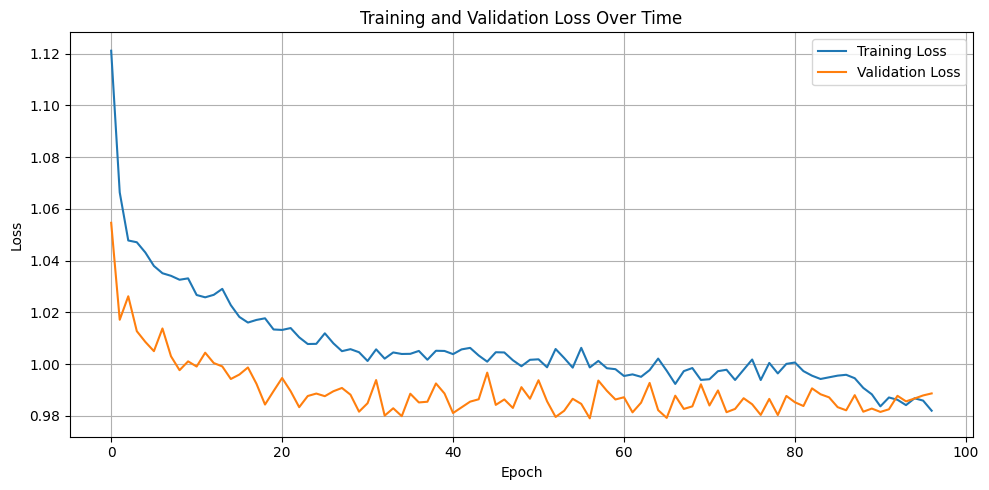

In [14]:
"""
Visualize both training and validation losses
This block plots the training and validation loss curves over epochs to help monitor
model convergence and detect overfitting or underfitting.
"""

# Check if loss history variables exist before plotting
if 'train_loss_history' in locals() and 'val_loss_history' in locals() and len(train_loss_history) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Save plot before showing it
    plt.tight_layout()
    loss_plot_path = os.path.join(current_run_dir, f"loss_curves_{timestamp}.png")
    plt.savefig(loss_plot_path)
    print(f"Loss curves saved to the specified path.")
else:
    print("Skipping loss curve visualization (no training history available)")

"""
Evaluate model on training and validation sets
This block computes and prints the accuracy of the trained model on both the training
and validation datasets using the evaluate_model_accuracy function.
"""

train_accuracy = evaluate_model_accuracy(model, train_loader)
val_accuracy = evaluate_model_accuracy(model, val_loader)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")

# Generate and Save Transition Matrix

In [15]:
"""
Extract and save transition matrix

This block evaluates the trained model to compute and save the state transition matrix,
as well as the full model for later inference. The transition matrix represents the
probability of transitioning from each current state to every possible next state,
given the average feature vector from the validation set.

Steps:
    1. Collect all features from the validation set and compute their mean.
    2. For each possible current state, use the model to predict the next state probabilities using the average features.
    3. Store these probabilities in a transition matrix.
    4. Save the transition matrix to disk for later use.
    5. Save the full model (weights and normalization stats) for inference.
"""
if not load_existing_model:
    # Set model to evaluation mode
    model.eval()

    # Extract transition matrices using validation data
    with torch.no_grad():
        # Compute average features across the validation dataset
        all_features = []
        for batch in val_loader:
            feats = batch[0]
            all_features.append(feats)

        avg_features = torch.cat(all_features, dim=0).mean(dim=0).to(device)

        # Create transition matrix
        n_states = len(state_to_index)
        transition_matrix = np.zeros((n_states, n_states))
        state_names = ['short', 'medium', 'long']

        for current_state in range(n_states):
            # Create tensor for current state
            state_tensor = torch.tensor([current_state], device=device)

            # Get next state probabilities
            logP = model(state_tensor, avg_features.unsqueeze(0))

            # Store transition probabilities
            transition_matrix[current_state] = torch.exp(logP[0]).cpu().numpy()

        # Save the transition matrix
        np.save(transition_matrix_path, transition_matrix)

        print("Transition matrix:")
        print(transition_matrix)
        print(f"\nThe transition matrix is saved to the specified path.")

        # Save full model for inference
        torch.save({
            'model_state_dict': model.state_dict(),
            'feature_means': train_dataset.feature_means,
            'feature_stds': train_dataset.feature_stds,
            'state_to_index': state_to_index
        }, delay_model_path)

        print(f"The full model is saved to the specified path.")
else:
    print("Skipping transition matrix generation (using loaded matrix)")

Transition matrix:
[[0.30845457 0.41636124 0.27518421]
 [0.26752174 0.45783651 0.27464172]
 [0.27562031 0.42717734 0.29720247]]

The transition matrix is saved to the specified path.
The full model is saved to the specified path.


# Inference

In [16]:
# Check if there is a loaded transition matrix
if 'transition_matrix' not in locals() or transition_matrix is None:
    # Try to load from the path
    try:
        transition_matrix = np.load(transition_matrix_path)
        print(f"Loaded transition matrix from {transition_matrix_path}")
    except Exception as e:
        print(f"Could not load transition matrix: {str(e)}")
        print("Using a default identity matrix instead")
        transition_matrix = np.eye(len(state_to_index))

# List of state names corresponding to matrix indices
state_names = ['short', 'medium', 'long']

# Print the transition matrix in a formatted table
print("Transition Matrix (probability of transitioning from row state to column state):")
print("-" * 70)
print(f"{'From/To':<10}", end="")
for state in state_names:
    print(f"{state:<15}", end="")
print()
print("-" * 70)

# Print each row of the transition matrix with state names
for i, row_state in enumerate(state_names):
    print(f"{row_state:<10}", end="")
    for j in range(transition_matrix.shape[1]):
        print(f"{transition_matrix[i, j]:.6f}    ", end="")
    print()

Transition Matrix (probability of transitioning from row state to column state):
----------------------------------------------------------------------
From/To   short          medium         long           
----------------------------------------------------------------------
short     0.308455    0.416361    0.275184    
medium    0.267522    0.457837    0.274642    
long      0.275620    0.427177    0.297202    
